# 🧠 Shaking Palsy Detection using Voice & Machine Learning
This notebook covers the complete ML pipeline for Parkinson's Disease detection using voice features.
We'll explore multiple models, perform evaluation, and export the best-performing one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import joblib


In [2]:
# Load the dataset
df = pd.read_csv("data/parkinsons.data")
df.head()


,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
# Drop unnecessary columns
df = df.drop(['name'], axis=1)

# Separate features and target
X = df.drop(['status'], axis=1)
y = df['status']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.2, stratify=y_resampled, random_state=42)


In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, y_proba)
    results[name] = {
        "Model": model,
        "ROC AUC": score,
        "Report": classification_report(y_test, y_pred, output_dict=True),
        "Confusion": confusion_matrix(y_test, y_pred)
    }

results


{'Logistic Regression': {'Model': LogisticRegression(max_iter=1000),
  'ROC AUC': 0.9448275862068966,
  'Report': {'0': {'precision': 0.8125,
    'recall': 0.8666666666666667,
    'f1-score': 0.8387096774193549,
    'support': 30},
   '1': {'precision': 0.8518518518518519,
    'recall': 0.7931034482758621,
    'f1-score': 0.8214285714285715,
    'support': 29},
   'accuracy': 0.8305084745762712,
   'macro avg': {'precision': 0.8321759259259259,
    'recall': 0.8298850574712644,
    'f1-score': 0.8300691244239632,
    'support': 59},
   'weighted avg': {'precision': 0.8318424356559949,
    'recall': 0.8305084745762712,
    'f1-score': 0.8302155744747326,
    'support': 59}},
  'Confusion': array([[26,  4],
         [ 6, 23]])},
 'Random Forest': {'Model': RandomForestClassifier(),
  'ROC AUC': 1.0,
  'Report': {'0': {'precision': 0.8823529411764706,
    'recall': 1.0,
    'f1-score': 0.9375,
    'support': 30},
   '1': {'precision': 1.0,
    'recall': 0.8620689655172413,
    'f1-score':

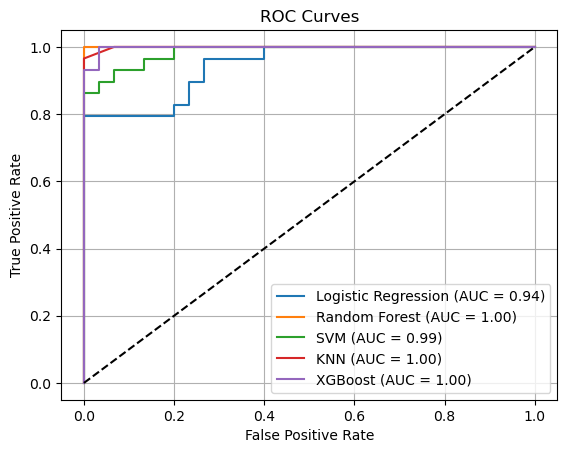

In [6]:
# Visualizing ROC-AUC scores
for name in results:
    fpr, tpr, _ = roc_curve(y_test, results[name]["Model"].predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {results[name]['ROC AUC']:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()


In [7]:
# Assume XGBoost is best (you can programmatically select based on score)
best_model = results["XGBoost"]["Model"]
joblib.dump(best_model, "models/final_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']